In [54]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from sklearn.neighbors import kneighbors_graph
import torch.nn as nn

In [55]:
df = pd.read_csv('heart.csv')

In [56]:
# df1 = pd.read_csv('heartds.csv')

In [57]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# le = LabelEncoder()
# df1['Sex'] = le.fit_transform(df1['Sex'])
features = df.drop('target', axis=1).values
scaler = StandardScaler()
features = scaler.fit_transform(features)
features[:5]

array([[-0.26843658,  0.66150409, -0.91575542, -0.37763552, -0.65933209,
        -0.41887792,  0.89125488,  0.82132052, -0.71228712, -0.06088839,
         0.99543334,  1.20922066,  1.08985168],
       [-0.15815703,  0.66150409, -0.91575542,  0.4791073 , -0.83386117,
         2.38733039, -1.00404855,  0.2559679 ,  1.40392824,  1.72713707,
        -2.24367514, -0.73197147,  1.08985168],
       [ 1.71659547,  0.66150409, -0.91575542,  0.76468824, -1.39623266,
        -0.41887792,  0.89125488, -1.04869198,  1.40392824,  1.30141672,
        -2.24367514, -0.73197147,  1.08985168],
       [ 0.72407944,  0.66150409, -0.91575542,  0.93603681, -0.83386117,
        -0.41887792,  0.89125488,  0.51689988, -0.71228712, -0.91232909,
         0.99543334,  0.23862459,  1.08985168],
       [ 0.834359  , -1.51170646, -0.91575542,  0.36487493,  0.93082177,
         2.38733039,  0.89125488, -1.87497657, -0.71228712,  0.70540823,
        -0.6241209 ,  2.17981673, -0.52212231]])

In [58]:
import torch
x = torch.tensor(features, dtype=torch.float)
x[:5]

tensor([[-0.2684,  0.6615, -0.9158, -0.3776, -0.6593, -0.4189,  0.8913,  0.8213,
         -0.7123, -0.0609,  0.9954,  1.2092,  1.0899],
        [-0.1582,  0.6615, -0.9158,  0.4791, -0.8339,  2.3873, -1.0040,  0.2560,
          1.4039,  1.7271, -2.2437, -0.7320,  1.0899],
        [ 1.7166,  0.6615, -0.9158,  0.7647, -1.3962, -0.4189,  0.8913, -1.0487,
          1.4039,  1.3014, -2.2437, -0.7320,  1.0899],
        [ 0.7241,  0.6615, -0.9158,  0.9360, -0.8339, -0.4189,  0.8913,  0.5169,
         -0.7123, -0.9123,  0.9954,  0.2386,  1.0899],
        [ 0.8344, -1.5117, -0.9158,  0.3649,  0.9308,  2.3873,  0.8913, -1.8750,
         -0.7123,  0.7054, -0.6241,  2.1798, -0.5221]])

In [59]:
# k = 10  # количество ближайших соседей
# adj_matrix = kneighbors_graph(features, n_neighbors=k, mode='connectivity', include_self=False)
# edge_index = np.array(adj_matrix.nonzero())
# edge_index = torch.tensor(edge_index, dtype=torch.long)

In [60]:
from sklearn.metrics.pairwise import euclidean_distances
distances = euclidean_distances(features)
threshold = 5.0
edge_index = (distances < threshold).nonzero()
edge_index = torch.tensor(edge_index).T
edge_index

tensor([[   0,    0],
        [   0,    3],
        [   0,    5],
        ...,
        [1024, 1022],
        [1024, 1023],
        [1024, 1024]])

In [61]:
edge_index = edge_index.T
print(edge_index.shape)

torch.Size([2, 542861])


In [62]:
y = torch.tensor(df['target'].values, dtype=torch.long)
edge_index = edge_index.clone().detach()
data = Data(x=x, edge_index=edge_index, y=y)
print(data)

Data(x=[1025, 13], edge_index=[2, 542861], y=[1025])


In [63]:
from sklearn.model_selection import train_test_split
train_mask, test_mask = train_test_split(range(len(y)), test_size=0.2, random_state=42)
len(train_mask), len(test_mask)

(820, 205)

In [64]:
# class CustomGCNConv(MessagePassing):
#     def __init__(self, in_channels, out_channels):
#         super().__init__(aggr='add')  # "Add" aggregation (Step 5).
#         self.lin = Linear(in_channels, out_channels, bias=False)
#         self.bias = Parameter(torch.empty(out_channels))
#         self.reset_parameters()

#     def reset_parameters(self):
#         self.lin.reset_parameters()
#         self.bias.data.zero_()

#     def forward(self, x, edge_index):
#         edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
#         x = self.lin(x)
#         row, col = edge_index
#         deg = degree(col, x.size(0), dtype=x.dtype)
#         deg_inv_sqrt = deg.pow(-0.5)
#         deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
#         norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
#         out = self.propagate(edge_index, x=x, norm=norm)
#         out = out + self.bias
#         return out

#     def message(self, x_j, norm):
#         return norm.view(-1, 1) * x_j

In [65]:
# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = CustomGCNConv(data.num_node_features, 16)
#         self.conv2 = CustomGCNConv(16, 2)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

In [66]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class EnhancedGNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EnhancedGNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)  # Dropout probability

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Dropout layer
        x = self.conv2(x, edge_index)
        # x = F.relu(x)
        # x = self.dropout(x)
        # x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

    def get_node_embeddings(self, data):
        # Извлечение эмбеддингов узлов после второго слоя
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)  # Выход второго слоя
        return x
        

# Создание модели
model = EnhancedGNNModel(in_channels=data.num_node_features, hidden_channels=16, out_channels=2)
model


EnhancedGNNModel(
  (conv1): GCNConv(13, 16)
  (conv2): GCNConv(16, 16)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [67]:
# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = GCNConv(data.num_node_features, 16)
#         self.conv2 = GCNConv(16, 2)  # Измените на количество классов

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)

In [68]:
# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = GCNConv(data.num_node_features, 16)
#         self.conv2 = GCNConv(16, data.num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GNNModel().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [70]:
test_losses = []
train_losses = []
test_accuracies = []
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_out = model(data)
        test_loss = F.nll_loss(test_out[test_mask], y[test_mask])
        test_losses.append(test_loss.item())
        
        # Вычисление точности на тестовой выборке
        pred = test_out.argmax(dim=1)
        correct = (pred[test_mask] == y[test_mask]).sum()
        acc = correct / len(test_mask)
        test_accuracies.append(acc.item())
    
    model.train()
    print(f'Epoch {epoch + 1}, Training Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {acc:.4f}')

Epoch 1, Training Loss: 2.9423, Test Loss: 2.8673, Test Accuracy: 0.0000
Epoch 2, Training Loss: 2.8673, Test Loss: 2.7966, Test Accuracy: 0.0000
Epoch 3, Training Loss: 2.7987, Test Loss: 2.7285, Test Accuracy: 0.0000
Epoch 4, Training Loss: 2.7282, Test Loss: 2.6625, Test Accuracy: 0.0976
Epoch 5, Training Loss: 2.6603, Test Loss: 2.5979, Test Accuracy: 0.4927
Epoch 6, Training Loss: 2.5956, Test Loss: 2.5343, Test Accuracy: 0.6683
Epoch 7, Training Loss: 2.5267, Test Loss: 2.4714, Test Accuracy: 0.6829
Epoch 8, Training Loss: 2.4656, Test Loss: 2.4081, Test Accuracy: 0.6829
Epoch 9, Training Loss: 2.3979, Test Loss: 2.3437, Test Accuracy: 0.6927
Epoch 10, Training Loss: 2.3318, Test Loss: 2.2776, Test Accuracy: 0.6976
Epoch 11, Training Loss: 2.2657, Test Loss: 2.2093, Test Accuracy: 0.7024
Epoch 12, Training Loss: 2.1988, Test Loss: 2.1386, Test Accuracy: 0.7024
Epoch 13, Training Loss: 2.1211, Test Loss: 2.0652, Test Accuracy: 0.7024
Epoch 14, Training Loss: 2.0563, Test Loss: 1.9

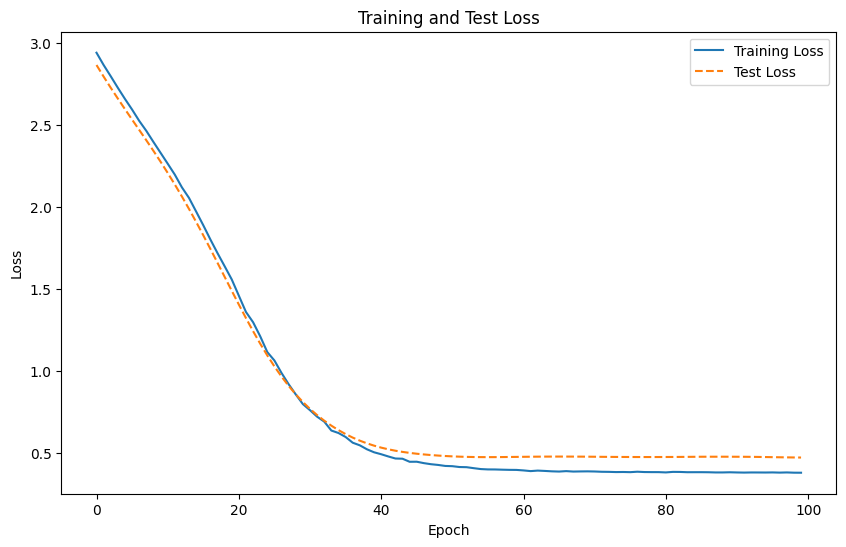

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

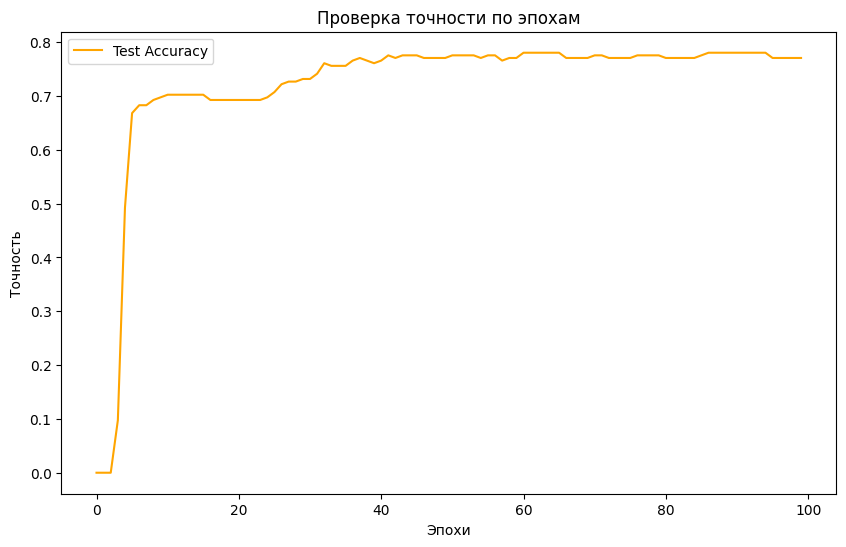

In [109]:
plt.figure(figsize=(10,6))
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.title('Проверка точности по эпохам')
plt.legend()

In [73]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [74]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[test_mask] == y[test_mask]).sum()
acc = correct / len(test_mask)
print(f'Final Accuracy: {acc:.4f}')

Final Accuracy: 0.7707


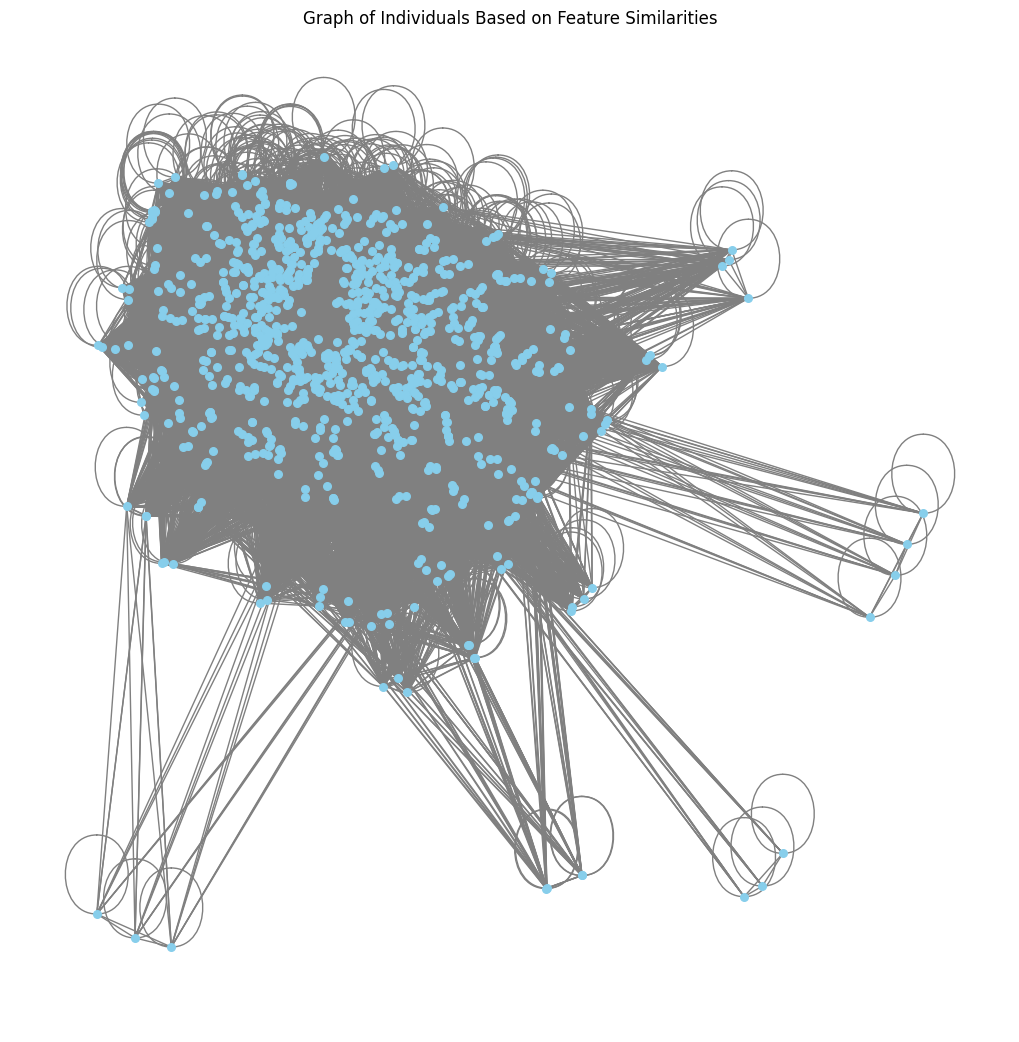

In [75]:

import networkx as nx
import matplotlib.pyplot as plt
edges = edge_index.numpy().T
G = nx.Graph()
G.add_edges_from(edges)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=30, node_color='skyblue', edge_color='gray')
plt.title("Graph of Individuals Based on Feature Similarities")
plt.show()

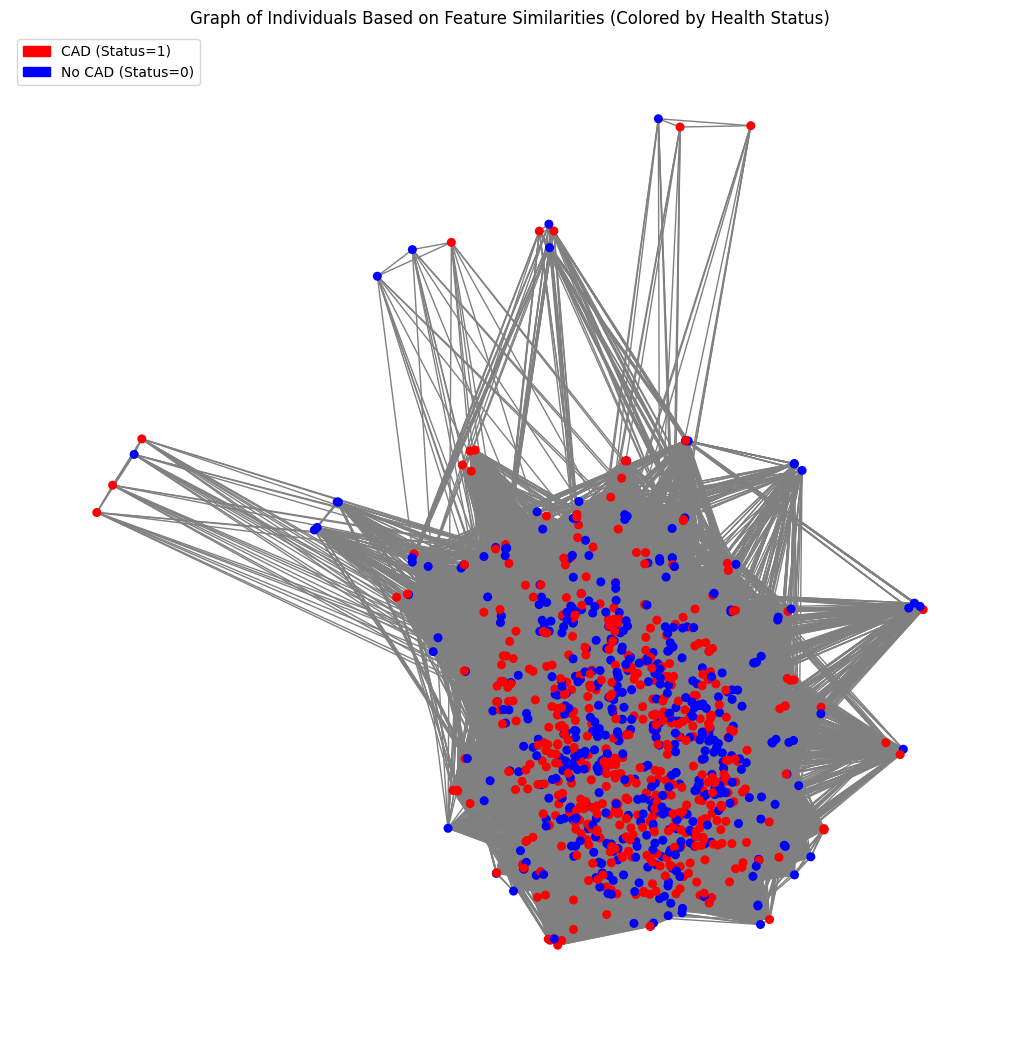

In [76]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
node_color = ['red' if status == 1 else 'blue' for status in df['target']]
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_color, edge_color='gray')
red_patch = mpatches.Patch(color='red', label='CAD (Status=1)')
blue_patch = mpatches.Patch(color='blue', label='No CAD (Status=0)')
plt.legend(handles=[red_patch, blue_patch], loc="upper left")
plt.title("Graph of Individuals Based on Feature Similarities (Colored by Health Status)")
plt.show()


In [86]:
# Плотность графа
density = nx.density(G)

# Вывод значения плотности
print(f"Graph Density: {density}")


Graph Density: 0.5162309451219512


In [80]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

node_embeddings = model.get_node_embeddings(data)

# Отключение градиентов и преобразование в NumPy
similarity_matrix = cosine_similarity(node_embeddings.detach().numpy())

print(similarity_matrix)


[[0.9999998  0.95711225 0.9664295  ... 0.99629104 0.9946681  0.9973634 ]
 [0.95711225 0.9999999  0.99937856 ... 0.9784614  0.92216134 0.9755861 ]
 [0.9664295  0.99937856 1.         ... 0.98494196 0.934802   0.98252076]
 ...
 [0.99629104 0.9784614  0.98494196 ... 0.99999994 0.98211557 0.99990696]
 [0.9946681  0.92216134 0.934802   ... 0.98211557 1.         0.9845703 ]
 [0.9973634  0.9755861  0.98252076 ... 0.99990696 0.9845703  0.99999994]]


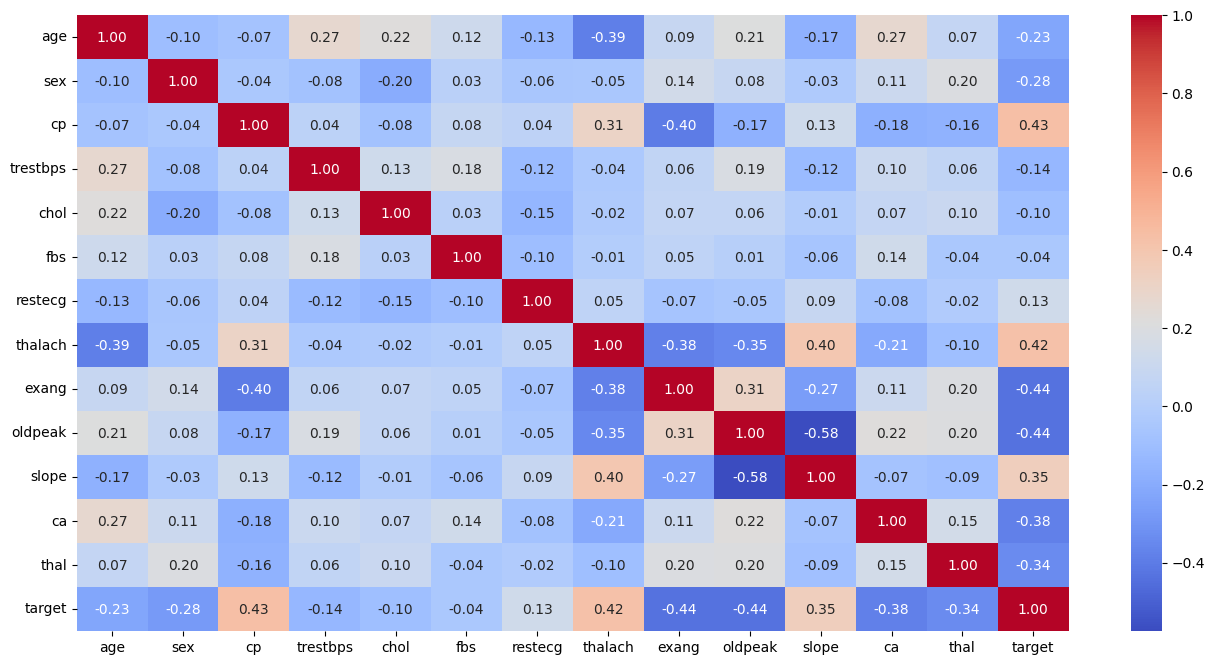

In [107]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

<Axes: >

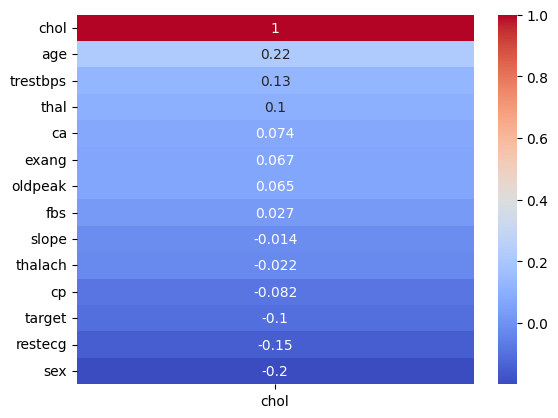

In [87]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True)[['chol']].sort_values(by='chol', ascending=False), annot=True, cmap='coolwarm')

<Axes: >

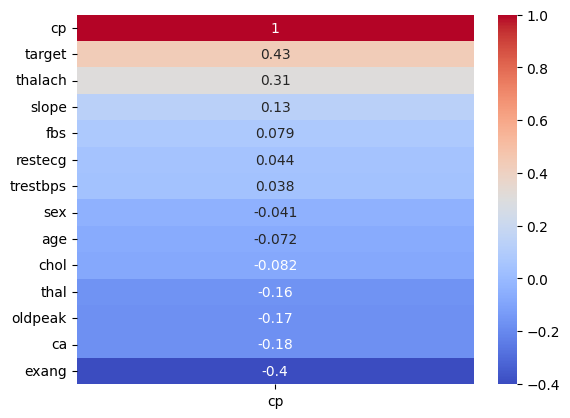

In [106]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True)[['cp']].sort_values(by='cp', ascending=False), annot=True, cmap='coolwarm')

<Axes: >

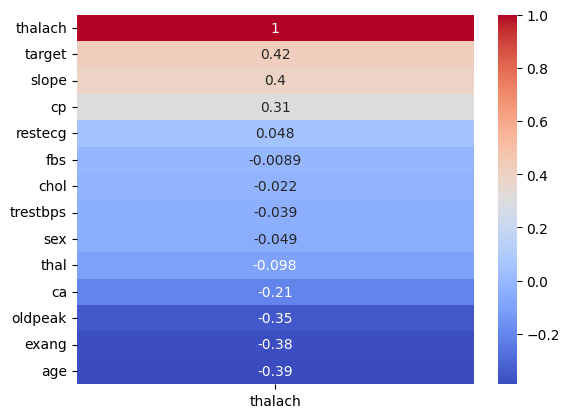

In [108]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True)[['thalach']].sort_values(by='thalach', ascending=False), annot=True, cmap='coolwarm')

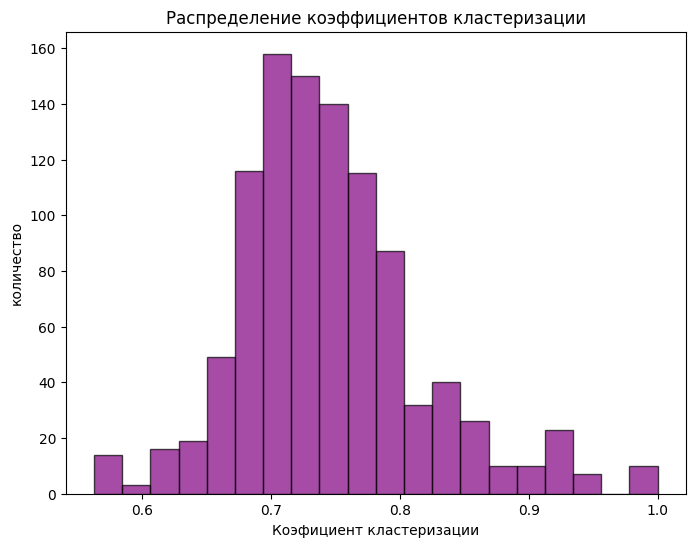

In [88]:
# Вычисление коэффициента кластеризации для каждого узла
clustering = nx.clustering(G)

# Получение значений для графика
clustering_values = list(clustering.values())

# Построение гистограммы
plt.figure(figsize=(8, 6))
plt.hist(clustering_values, bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.title("Распределение коэффициентов кластеризации")
plt.xlabel("Коэфициент кластеризации")
plt.ylabel("количество")
plt.show()


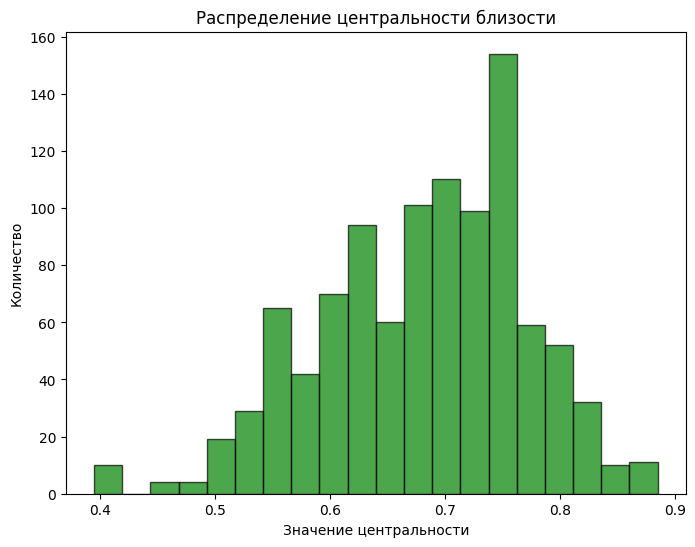

In [89]:
# Вычисление близости центральности
closeness = nx.closeness_centrality(G)

# Получение значений для графика
closeness_values = list(closeness.values())

# Построение гистограммы
plt.figure(figsize=(8, 6))
plt.hist(closeness_values, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title("Распределение центральности близости")
plt.xlabel("Значение центральности")
plt.ylabel("Количество")
plt.show()


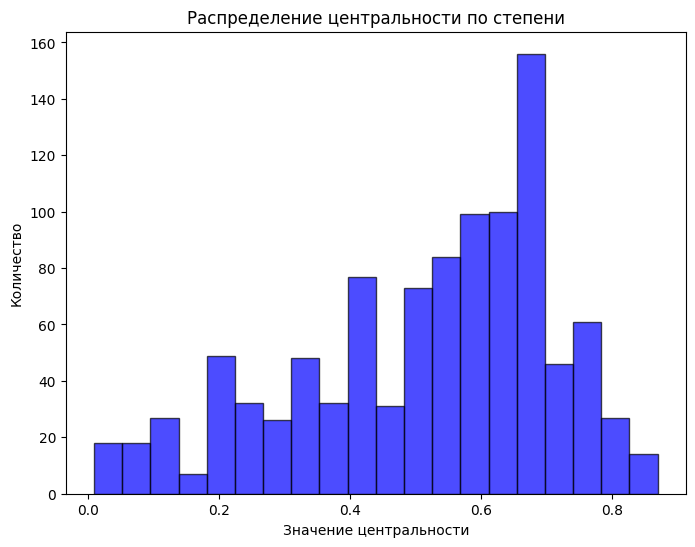

In [90]:
import matplotlib.pyplot as plt
import networkx as nx

# Вычисление степени центральности
centrality = nx.degree_centrality(G)

# Получение значений центральности для каждого узла
centrality_values = list(centrality.values())

# Построение гистограммы
plt.figure(figsize=(8, 6))
plt.hist(centrality_values, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Распределение центральности по степени")
plt.xlabel("Значение центральности")
plt.ylabel("Количество")
plt.show()

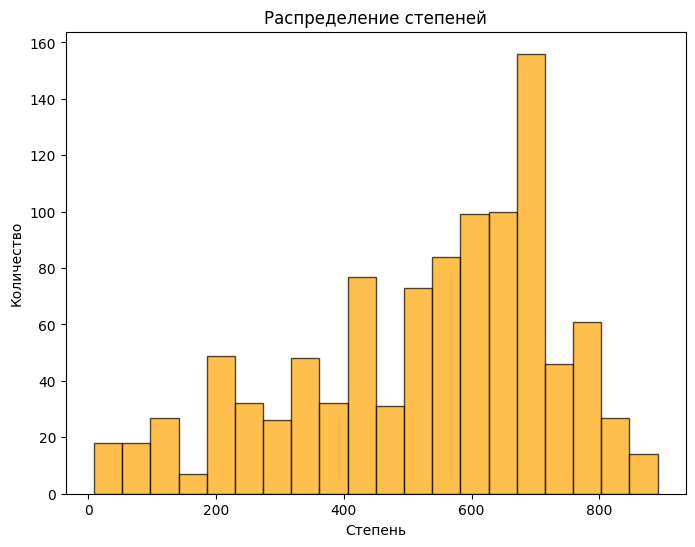

In [91]:
# Вычисление степеней узлов
degrees = [G.degree(node) for node in G.nodes()]

# Построение гистограммы распределения степеней
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.title("Распределение степеней")
plt.xlabel("Степень")
plt.ylabel("Количество")
plt.show()


In [92]:
degrees = [deg for _, deg in G.degree()]
print(degrees)

[772, 759, 617, 662, 761, 462, 431, 456, 253, 456, 711, 568, 726, 561, 703, 601, 592, 658, 592, 671, 726, 481, 722, 614, 673, 686, 551, 891, 818, 567, 761, 614, 618, 582, 672, 392, 661, 222, 554, 625, 782, 707, 790, 369, 672, 460, 526, 369, 522, 700, 587, 703, 388, 754, 528, 346, 876, 876, 830, 469, 614, 222, 522, 701, 561, 242, 632, 629, 346, 588, 690, 699, 435, 558, 657, 276, 697, 754, 684, 691, 665, 558, 602, 625, 608, 388, 482, 832, 493, 369, 689, 697, 527, 520, 585, 762, 349, 630, 585, 732, 582, 722, 697, 614, 754, 666, 394, 670, 626, 407, 750, 401, 680, 554, 533, 209, 684, 818, 697, 443, 818, 550, 273, 710, 273, 774, 587, 506, 715, 608, 687, 695, 421, 586, 625, 346, 719, 671, 682, 401, 587, 832, 650, 589, 798, 526, 698, 612, 534, 682, 629, 407, 672, 521, 589, 222, 665, 460, 703, 715, 682, 790, 678, 550, 506, 462, 765, 832, 421, 663, 730, 469, 719, 538, 684, 774, 651, 564, 635, 469, 813, 392, 700, 707, 222, 703, 644, 209, 506, 632, 671, 684, 608, 590, 565, 444, 762, 659, 730, 637,

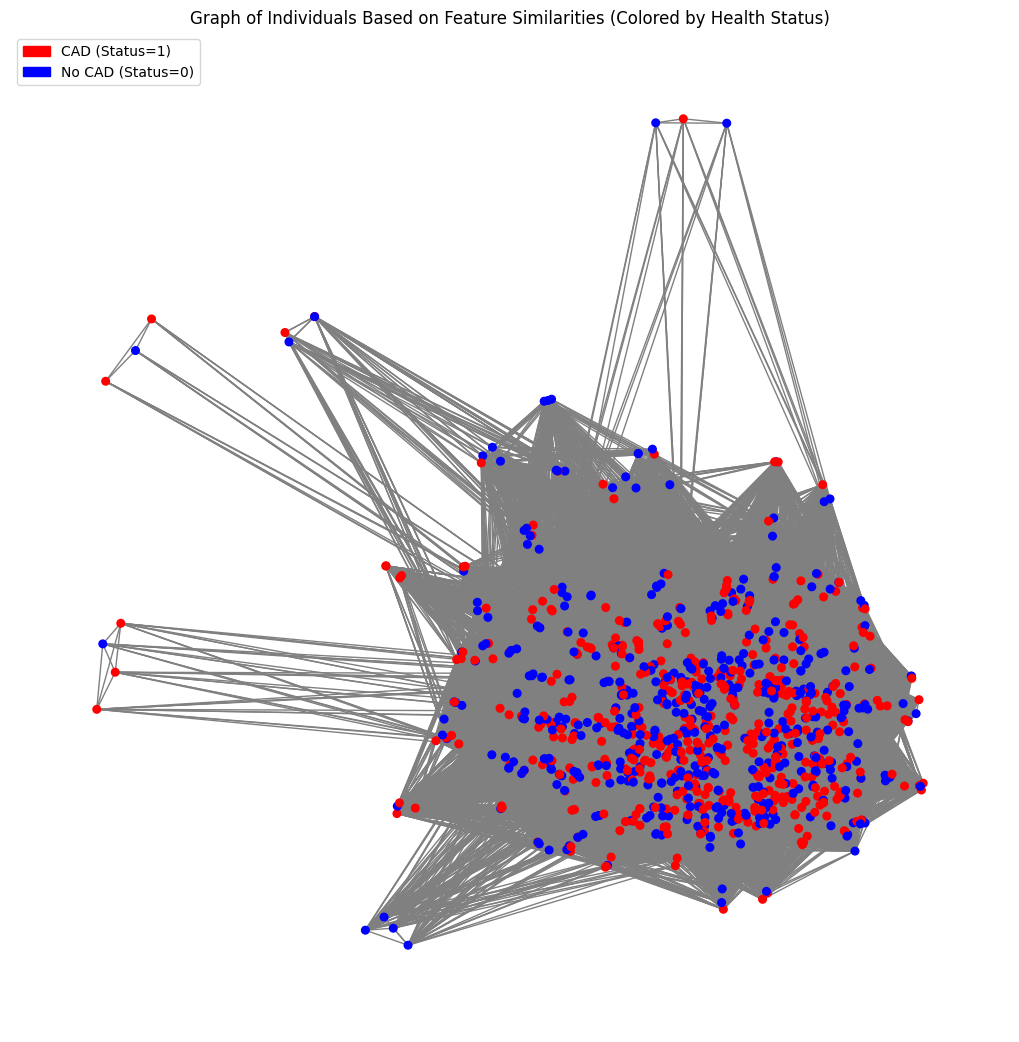

In [93]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
node_color = ['red' if status == 1 else 'blue' for status in df['target']]
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_color, edge_color='gray')
red_patch = mpatches.Patch(color='red', label='CAD (Status=1)')
blue_patch = mpatches.Patch(color='blue', label='No CAD (Status=0)')
plt.legend(handles=[red_patch, blue_patch], loc="upper left")
plt.title("Graph of Individuals Based on Feature Similarities (Colored by Health Status)")
plt.show()

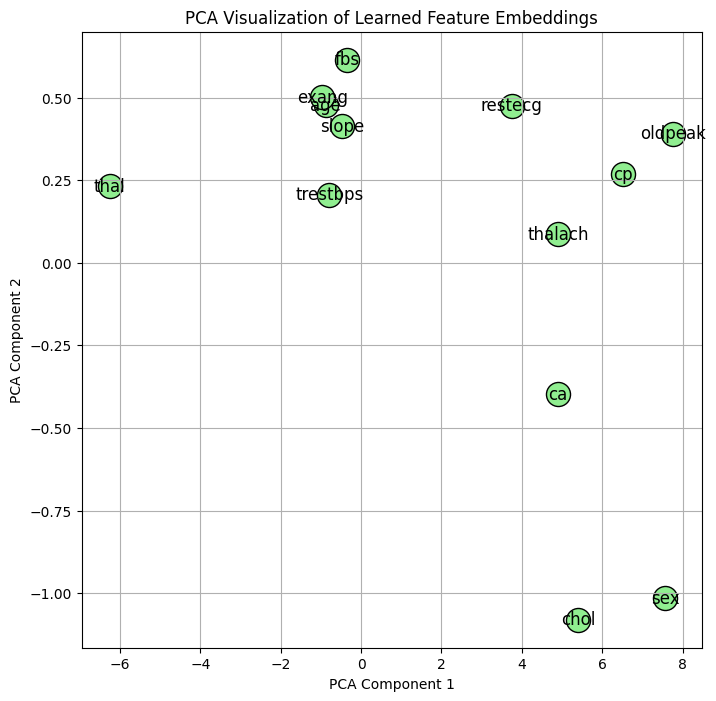

In [94]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Перевод модели в режим оценки для получения вложений
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index)  # Получение скрытых вложений после первого слоя

# Применение PCA для уменьшения размерности до 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings.cpu().numpy())

# Названия признаков для отображения на графике (если это актуально)
feature_names = df.drop('target', axis=1).columns

# Построение графика
plt.figure(figsize=(8, 8))
for i, name in enumerate(feature_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], s=300, color='lightgreen', edgecolor='black')
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], name, fontsize=12, ha='center', va='center')

plt.title('PCA Visualization of Learned Feature Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


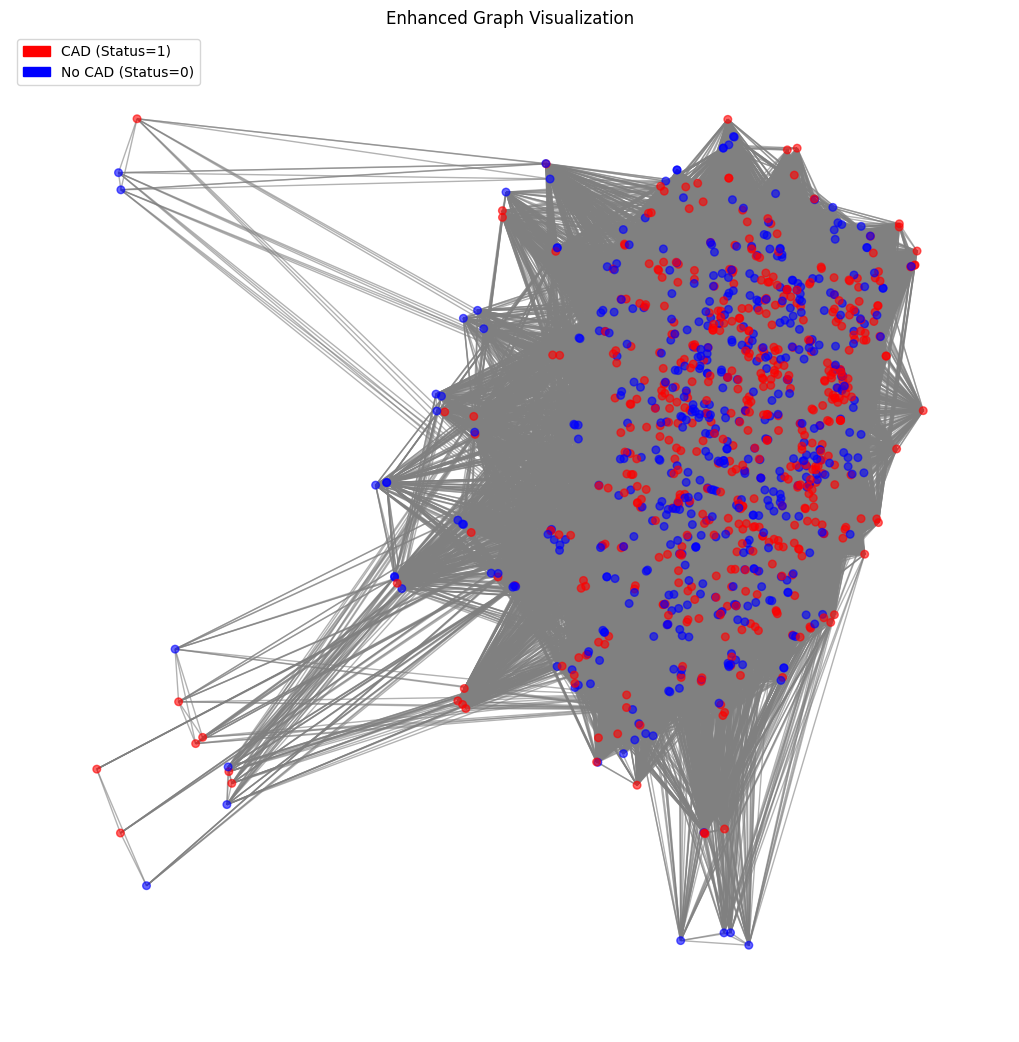

In [95]:
# Новая функция для создания edge_index на основе k-ближайших соседей
from sklearn.neighbors import kneighbors_graph
k = 10  # Попробуйте разные значения k
adj_matrix = kneighbors_graph(features, k, mode='connectivity', include_self=False)
edge_index = np.array(adj_matrix.nonzero())
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Улучшенная визуализация
plt.figure(figsize=(10, 10))
node_color = ['red' if status == 1 else 'blue' for status in df['target']]
pos = nx.spring_layout(G, seed=42)  # Новая раскладка
nx.draw(G, pos, node_size=30, node_color=node_color, edge_color='gray', alpha=0.6)
plt.legend(handles=[red_patch, blue_patch], loc="upper left")
plt.title("Enhanced Graph Visualization")
plt.show()
